In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import xgboost as xgb
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming results_path is already defined as per your prompt
results_path = Path().cwd().parent / "results"
results_path.mkdir(parents=True, exist_ok=True)


In [7]:
data_path = Path().cwd().parent / "data" / "electricity_prediction.csv"
results_path = Path().cwd().parent / "results"


## 1. Connect to data

In [8]:
try:
    # Load data with header=None as the file lacks headers
    df = pd.read_csv(data_path, header=None)
except FileNotFoundError:
    print("Error: Data file not found. Please check the path.")
else:
    # Rename columns
    column_names = [f'Hour_{i}' for i in range(1, 7)] + ['Target']
    df.columns = column_names
    print("Data Loaded Successfully.")

df.info()


Data Loaded Successfully.
<class 'pandas.DataFrame'>
RangeIndex: 139571 entries, 0 to 139570
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Hour_1  139571 non-null  float64
 1   Hour_2  139571 non-null  float64
 2   Hour_3  139571 non-null  float64
 3   Hour_4  139571 non-null  float64
 4   Hour_5  139571 non-null  float64
 5   Hour_6  139571 non-null  float64
 6   Target  139571 non-null  float64
dtypes: float64(7)
memory usage: 7.5 MB


In [9]:
display(df)


,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Target
0,71.770335,320.574163,401.913876,344.497608,440.191388,440.191388,425.837321
1,62.200957,320.574163,344.497608,440.191388,440.191388,425.837321,397.129187
2,71.770335,358.851675,440.191388,440.191388,425.837321,397.129187,344.497608
3,66.985646,296.650718,440.191388,425.837321,397.129187,344.497608,344.497608
4,66.985646,330.143541,425.837321,397.129187,344.497608,344.497608,311.004785
...,...,...,...,...,...,...,...
139566,71.770335,449.760766,263.157895,234.449761,234.449761,248.803828,244.019139
139567,81.339713,358.851675,234.449761,234.449761,248.803828,244.019139,143.540670
139568,71.770335,358.851675,234.449761,248.803828,244.019139,143.540670,114.832536
139569,100.478469,430.622010,248.803828,244.019139,143.540670,114.832536,138.755981


## 2. Exploratory Data Analysis (EDA)
Create the violin plots to visualize the distribution.

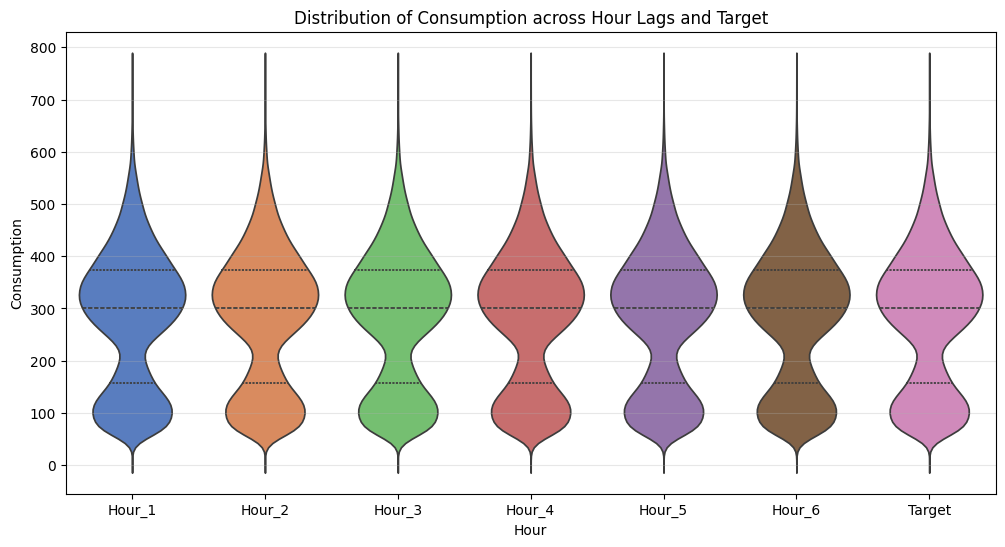

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
# Melts the dataframe to a long format suitable for seaborn
df_melted = df.melt(var_name='Hour', value_name='Consumption')
sns.violinplot(x='Hour', y='Consumption', data=df_melted, inner="quartile", hue="Hour", palette="muted")
plt.title("Distribution of Consumption across Hour Lags and Target")
plt.grid(axis='y', alpha=0.3)
plt.savefig(results_path / "consumption_violinplot.png", dpi=300)
plt.show()


Those violin plots are perfect—they clearly confirm the multimodal distribution. We can see two distinct "swells" in each violin, likely representing the base load during off-peak hours (the lower swell around 100) and the higher activity during peak hours (the larger swell between 300 and 400).

The fact that all columns look identical is great news; it confirms our data lags are consistent and haven't been corrupted by weird scaling or shifts.